# **Use logistic regression to predict when customers are going to transact**

## 1. Data preprocessing (understanding of my data)

## 2. Data visualization (analyzing relationships between key variables)

## 3. Determine the causes for a transaction by using logistic regression  

## 4. Assess the performance of my model

## 5. Generate 5 sample predictions for input values of my choosing


Author: Mia (Yuhsin Hou)

# Import necessary packages

In [0]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import statsmodels.api as sm
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as ticker
from scipy import stats
from pylab import rcParams
from matplotlib.pyplot import MultipleLocator
from pandas.plotting import scatter_matrix

rcParams['figure.figsize'] = (20, 8)
sns.set_style('darkgrid')
plt.style.use('seaborn-darkgrid')

from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from patsy import dmatrices
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# **Part 1 - Data preprocessing (understanding of my data)**

## Load data

In [225]:
# Read data from Google Sheet
data_path = "https://docs.google.com/spreadsheets/d/e/2PACX-1vQmeOF-CZeFPa_vPWAEV_4oB05YTIaBpDKoW82jVUEeA6531NuHUNecM1VIQPsCpyePdqjQgA_lFKCo/pub?gid=1578937664&single=true&output=csv"
transac_df = pd.read_csv(data_path)
transac_df.head(10)

,row,transaction,salary_usd,is_male,is_married,is_college,is_professional,is_senior,is_employed,is_single_income,children_present,is_renter,lives_in_house,is_english_primary_language,previously_disney_customer,previous_streaming_service_customer
0,653,0,25000,1,0,0,0,0,0,1,0,1,0,1,0,0
1,546,0,7000,0,0,0,0,0,0,1,1,1,1,1,0,0
2,463,0,25000,1,0,0,1,0,0,1,1,1,0,1,1,0
3,93,1,124000,0,1,1,1,0,0,0,0,0,1,1,0,0
4,672,1,84000,0,1,0,1,0,0,0,1,0,1,1,0,0
5,273,0,66000,1,0,1,0,0,0,1,0,1,0,0,0,0
6,278,0,41000,0,0,0,0,0,0,1,1,1,1,0,0,0
7,204,0,35000,0,0,1,1,0,0,1,0,1,0,1,0,0
8,456,0,40000,0,0,0,1,0,0,1,0,1,0,1,0,0
9,414,1,124000,1,1,1,0,0,0,1,1,0,1,1,1,0


## Interpret data

In [226]:
# See each column name

list(transac_df)

['row',
 'transaction',
 'salary_usd',
 'is_male',
 'is_married',
 'is_college',
 'is_professional',
 'is_senior',
 'is_employed',
 'is_single_income',
 'children_present',
 'is_renter',
 'lives_in_house',
 'is_english_primary_language',
 'previously_disney_customer',
 'previous_streaming_service_customer']

In [227]:
transac_df.shape

(505, 16)

The data contains 505 transactions with 16 features.

## Feature difinition

Each row represents a transaction, each column contains transaction attributes.

Here's my interpretation:

- row: the order number of each row. 
- transaction: whether the transaction has been made. 1 means yes, 0 means no. 
- salary_usd: customers salary in USD.
- is_male: whether the costomer is male. 1 means male, 0 means female. 
- is_married: whether this costomer is married. 1 means married, 0 means single. 
- is_college: whether this customer is a college student. 1 means yes, 0 means not.  
- is_professional: whether this customer earns his / her living from a specified professional activity. 1 means yes, 0 means not.  
- is_senior: whether this customer is senior with the age above 65 years old. 1 means yes, 0 means not. 
- is_employed: whether this customer is employed (work regularly at the same job a minimum of 1 hour for compensation and benefits). 1 means yes, 0 means no.
- is_single_income: whether this customer is having single income, while with only 1 income in a household can be intepreted as single income as well. 1 means yes, 0 means not.
- children_present: whether this transaction is for a child present. 1 means yes, 0 means not.
- is_renter: whether this customer is renter. 1 means yes, 0 means not.
- lives_in_house: whether this customer lives in house. 1 means yes, 0 means not.
- is_english_primary_language: whether the primary language of this customer is English. 1 means yes, 0 means not.
- previously_disney_customer: whether this customer is previously disney customer or not. 1 means yes, 0 means not.
- previous_streaming_service_customer: whether this customer is previous streaming service customer or not. 1 means yes, 0 means not.

## The type of the columns can be found out as follows:

In [228]:
transac_df.dtypes

row                                    int64
transaction                            int64
salary_usd                             int64
is_male                                int64
is_married                             int64
is_college                             int64
is_professional                        int64
is_senior                              int64
is_employed                            int64
is_single_income                       int64
children_present                       int64
is_renter                              int64
lives_in_house                         int64
is_english_primary_language            int64
previously_disney_customer             int64
previous_streaming_service_customer    int64
dtype: object

We do not have categorical features. 

## Summary of descriptive statistics

Since this dataset contains most of the binary variables, I will just check the 'salary_usd' feature here.  

In [229]:
transac_df['salary_usd'].describe().to_frame()

,salary_usd
count,505.000000
mean,58223.762376
std,39098.058320
min,0.000000
25%,25000.000000
50%,55000.000000
75%,86000.000000
max,124000.000000


My data seems normal and clean. 

## Identify missing value

In [230]:
# Check if there are missing values and the data type of each features.
total = transac_df.isnull().sum().sort_values(ascending=False)
frame = [total]
missing_df = pd.concat(frame, axis=1, keys = ['Total'])
missing_df

,Total
previous_streaming_service_customer,0
previously_disney_customer,0
is_english_primary_language,0
lives_in_house,0
is_renter,0
children_present,0
is_single_income,0
is_employed,0
is_senior,0
is_professional,0


There is no missing value

# **Part 2 - Data visualization (analyzing relationships between key variables)**

## First of all, I want to find out the number of customers who transacted and those who didn't. 

## So review the transaction variable.

In [231]:
# Count unique values in 'transaction'.
count = transac_df['transaction'].value_counts()

# Compute the percentage of unique values in 'attrit'.
percent = (transac_df['transaction'].value_counts() / transac_df['transaction'].count() *100).round(2)

# Create a summary dataframe
frames = [count, percent]
transac_agg = pd.concat(frames, axis=1, keys = ['Count', 'Percent'])
transac_agg
# transac_df

,Count,Percent
0,411,81.39
1,94,18.61


## Visualize transaction variable across 2 classes

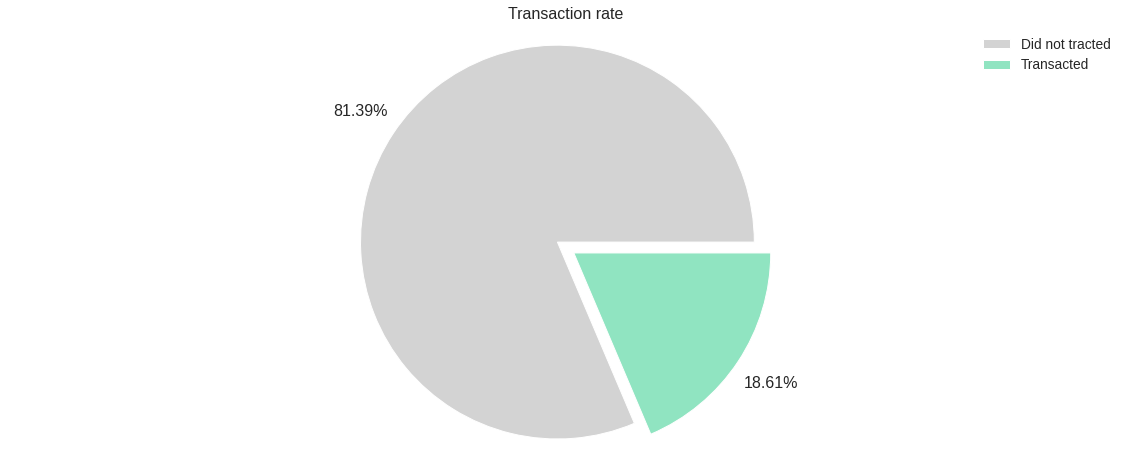

In [232]:
fig, ax = plt.subplots()

# set font size. 
plt.rcParams['font.size']=16

# set color palette.
color_palette_list = ['lightgrey', '#90e4c1']

# make a pie chart. 
percentages = percent.values.tolist()
explode=(0.1, 0)
labels = ['Did not tracted', 'Transacted']
ax.pie(percentages, colors = color_palette_list[0:2], autopct = '%1.2f%%', explode=explode, shadow = False, startangle = 0, pctdistance = 1.2, labeldistance = 1.4)
ax.axis('equal')
ax.set_title('Transaction rate', fontsize = 16)
ax.legend(labels)

Obviously, we are dealing with inblanced data, most of customers did not transact.

## Drop the columns that are not germane to the analysis

In [233]:
# Drop 'row' data.
transac_df.drop(['row'], axis =1, inplace = True)

# Get a concise summary of the dataframe. 
transac_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype
---  ------                               --------------  -----
 0   transaction                          505 non-null    int64
 1   salary_usd                           505 non-null    int64
 2   is_male                              505 non-null    int64
 3   is_married                           505 non-null    int64
 4   is_college                           505 non-null    int64
 5   is_professional                      505 non-null    int64
 6   is_senior                            505 non-null    int64
 7   is_employed                          505 non-null    int64
 8   is_single_income                     505 non-null    int64
 9   children_present                     505 non-null    int64
 10  is_renter                            505 non-null    int64
 11  lives_in_house                       505 non-null    int64

## Check the overview correlation coefficient with transaction

,transaction
transaction,1.000
salary_usd,0.622
is_married,0.397
is_professional,0.254
is_college,0.231
lives_in_house,0.214
previously_disney_customer,0.153
is_english_primary_language,0.124
previous_streaming_service_customer,0.086
children_present,0.008


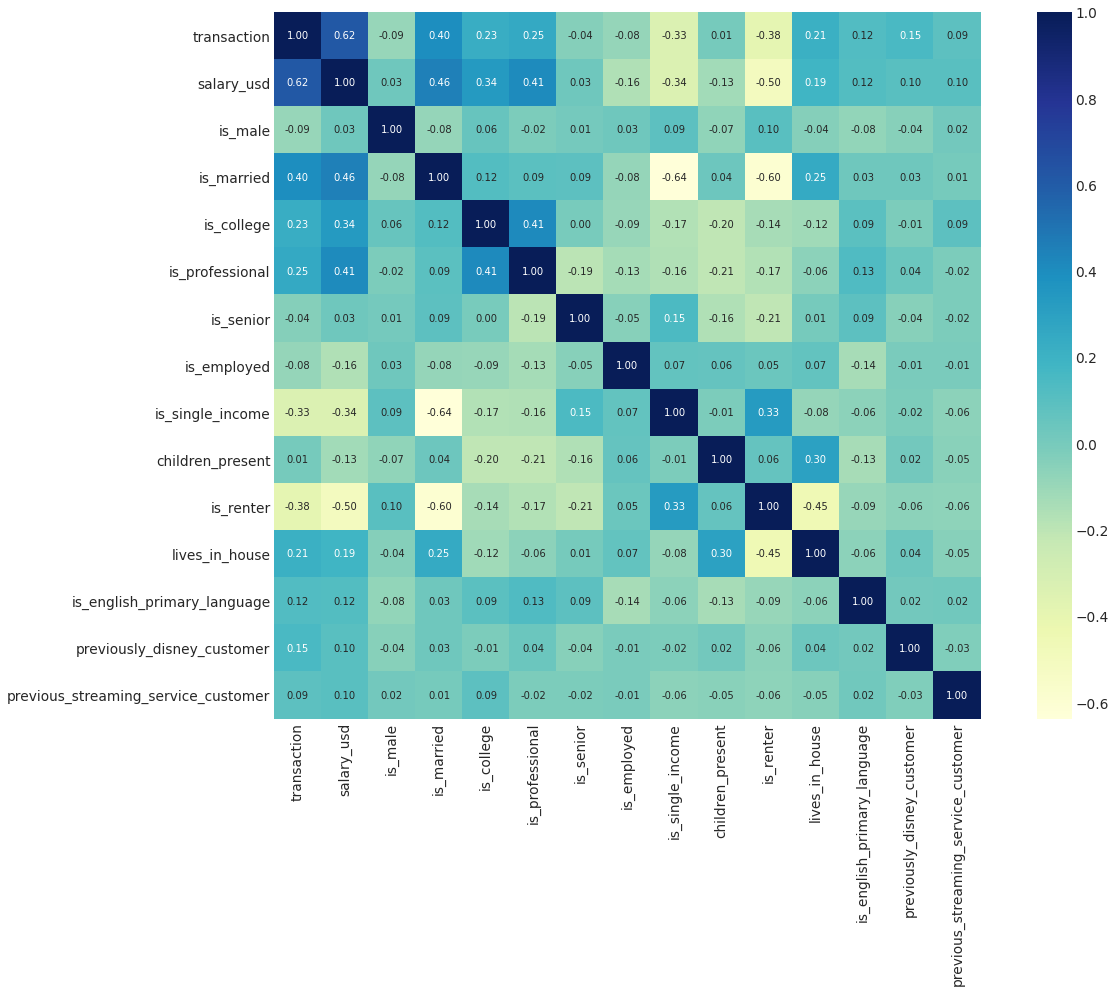

In [234]:
# Compute correlation matrix. 
corrmatrix = transac_df.corr('spearman')

# Plot heatmap.
plt.rcParams['figure.figsize'] = (20, 13)
hm = sns.heatmap(corrmatrix, square = True, annot = True, cmap = 'YlGnBu', fmt = '.2f', annot_kws = {'size':10})
sns.set(font_scale=1.25)

# Print a dataframe to see how much each variable correlates with transaction.
corrmatrix['transaction'].sort_values(ascending=False).round(3).head(10).to_frame()

**My observations:**

We can see the heatmap shows only salary_usd correlates to the transaction most, others coefficient are below 0.5. 

**Our question is to predict when customers are going to transact, which I consider we should try to analyze a customer's propensity and behaviour to purchase, understand the customer / market segmentation.**

It is not only important to predict likelihood to buy for first-time buyers, but it is equally important to predict likelihood to buy for repeat buyers. 

Thus, except the salary_usd, I would like to explore some of features which I think should be a good predictor, and visualize them to get much clearer picture of the correlation with transaction.

  1. previous_streaming_service_customer: to understand whether they were make transaction again, see if they are repeat buyers. 
  2. previously_disney_customer: to understand whether they were make transaction again, see if they are repeat buyers. 
  3. is_english_primary_language: I am quite curious about this feature, I do not know whether this variable matters, I know the primary language of Disney is English, but they are having a global market. By understanding this feature, might be healful to understand the main customer / target of Disney. 
  4. children_present: my assumption is that Disney starts from everyone's childhood. Let's look at whether children affect transaction.   
  5. salary_usd: heatmap shows it has stronger linear relationship with transaction. 

## 1. Previous_streaming_service_customer and transaction

(0.0, 400.0)

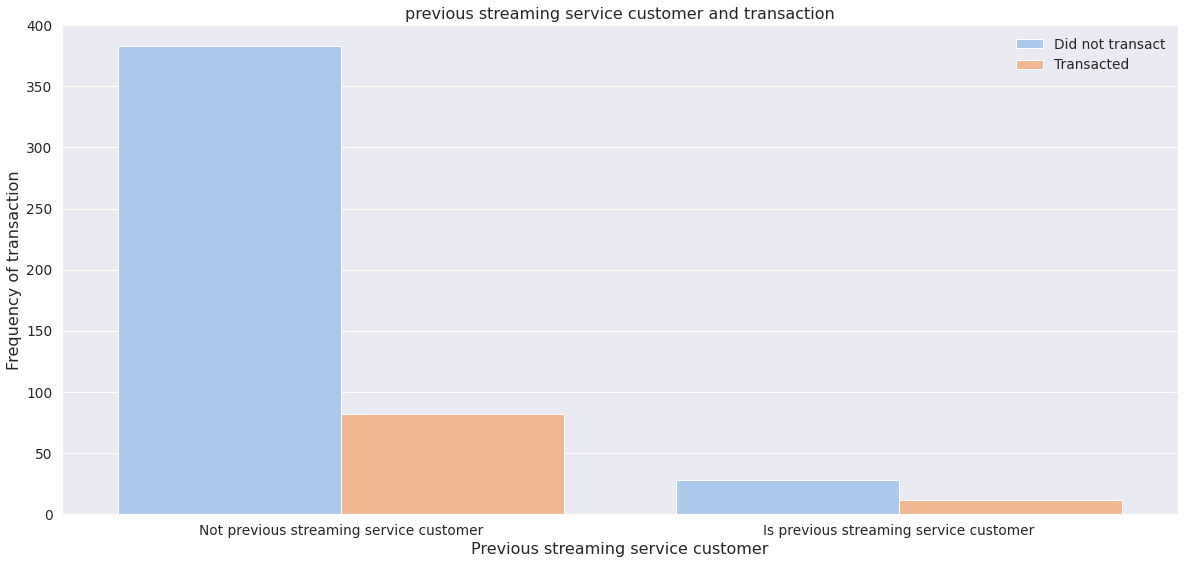

In [235]:
# Set size of plot.
rcParams['figure.figsize'] = (20, 9)

# Make a countplot.
ax = sns.countplot(x = 'previous_streaming_service_customer', hue = 'transaction', data = transac_df, palette = sns.color_palette('pastel'))

# Format legend.
plt.legend(['Did not transact', 'Transacted'])

# Set x and y lable name and the title.
ax.set_xlabel('Previous streaming service customer', fontsize = 16)
ax.set_ylabel('Frequency of transaction', fontsize = 16)
ax.set_title('previous streaming service customer and transaction', fontsize = 16)

# Reset x ticks label.
plt.xticks((0, 1), ['Not previous streaming service customer', 'Is previous streaming service customer'])

# Set x axis range.
plt.ylim(0, 400)

Customers are likely not repeatedly transacted after the first buy. 

## 2. Previously_disney_customer and transaction

(0.0, 1.0)

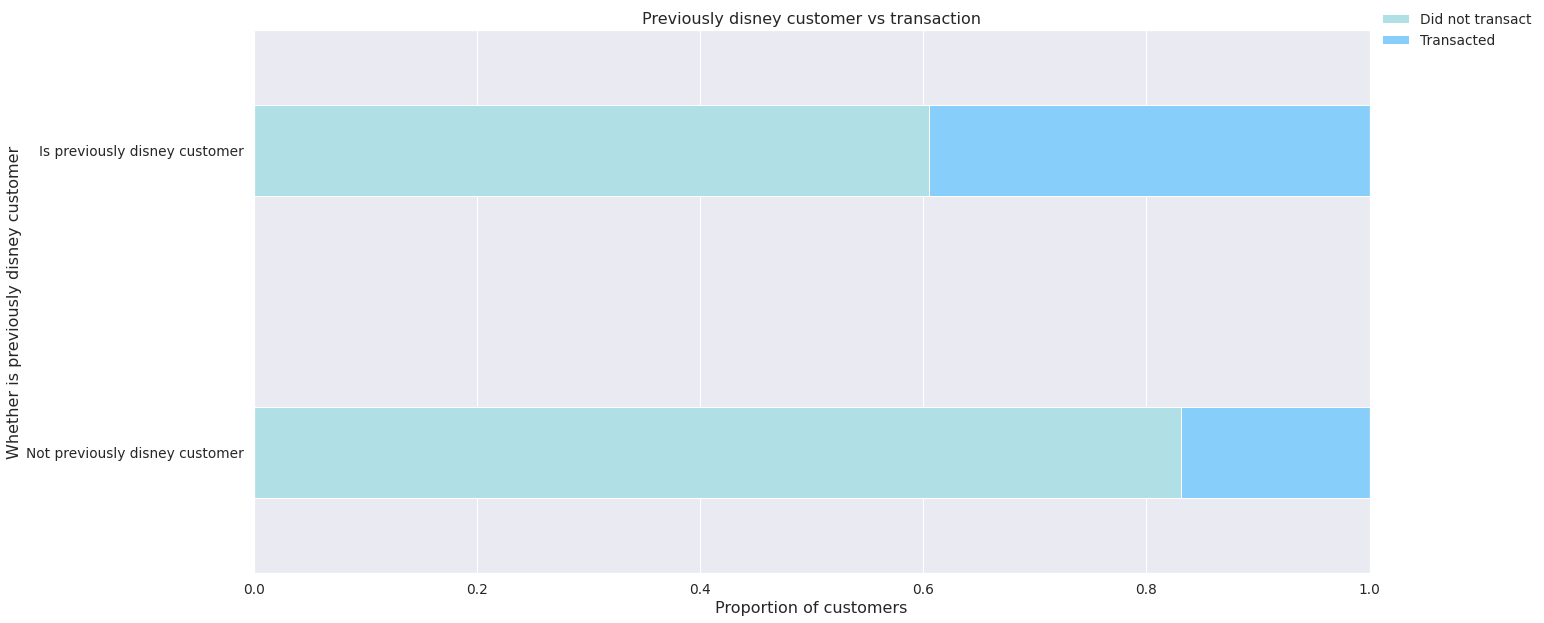

In [236]:
# Set figure size. 

rcParams['figure.figsize'] = (20, 10)

# Make a stackedplot
table = pd.crosstab(transac_df.previously_disney_customer, transac_df.transaction)
proportion = table.div(table.sum(1).astype(float), axis = 0)

proportion.plot.barh(stacked = True, color = ['powderblue', 'lightskyblue'], width = 0.3, legend = True)
plt.title('Previously disney customer vs transaction', fontsize = 16)
plt.xlabel('Proportion of customers', fontsize = 16)
plt.ylabel('Whether is previously disney customer', fontsize = 16)

# Reset y ticks label.
plt.yticks((0, 1), ['Not previously disney customer', 'Is previously disney customer'])

# Set legend format 
labels = ['Did not transact', 'Transacted']
plt.legend(bbox_to_anchor=(1,1), loc='center left', labels = labels)

# Set the range for x axis. 
plt.xlim([0, 1])

Customer tend to repeatedly transacted.

## 3. Is_english_primary_language and transaction

(0.0, 1.0)

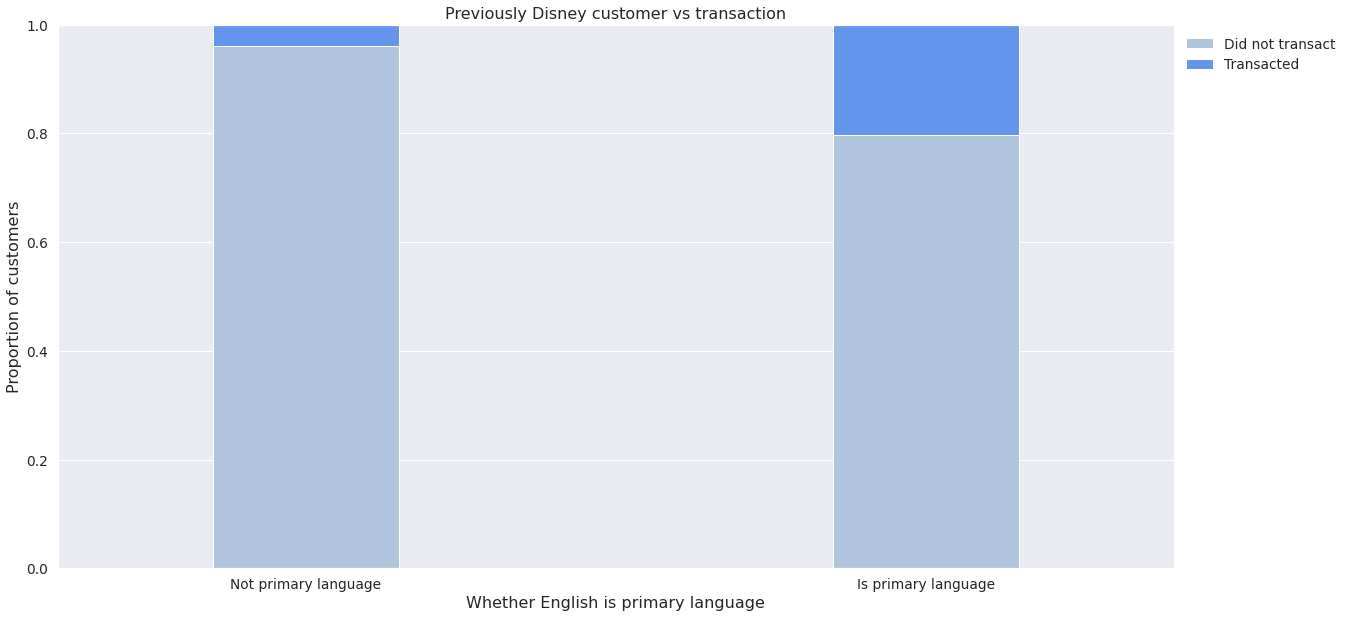

In [237]:
# Set figure size. 
rcParams['figure.figsize'] = (20, 10)

# Make a stackedplot
table = pd.crosstab(transac_df.is_english_primary_language, transac_df.transaction)
proportion = table.div(table.sum(1).astype(float), axis = 0)

ax = proportion.plot.bar(stacked = True, color = ['lightsteelblue', 'cornflowerblue'], width = 0.3, legend = True, rot = 0)
plt.title('Previously Disney customer vs transaction', fontsize = 16)
plt.xlabel('Whether English is primary language', fontsize = 16)
plt.ylabel('Proportion of customers', fontsize = 16)

# Reset y ticks label.
plt.xticks((0, 1), ['Not primary language', 'Is primary language'])

# Set legend format 
labels = ['Did not transact', 'Transacted']
plt.legend(bbox_to_anchor=(1, 1), labels = labels)

plt.ylim(0, 1)

Customer who's primary language is English transacted more than ones who's English is not primary language.   

## 4. Children present abd transaction

(0.0, 300.0)

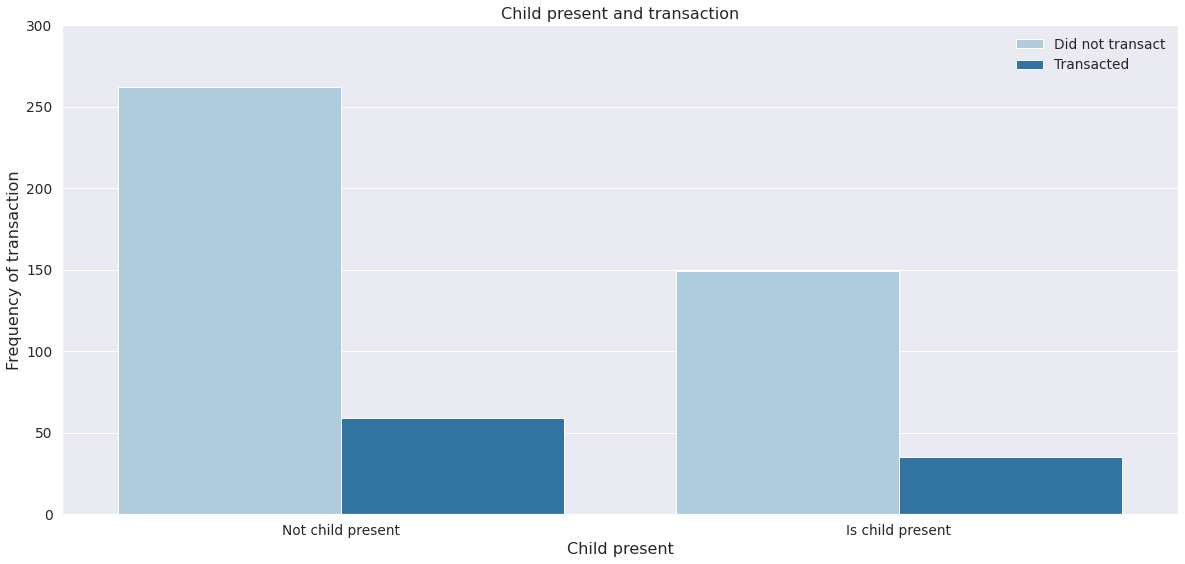

In [238]:
# Set size of plot.
rcParams['figure.figsize'] = (20, 9)

# Make a countplot.
ax = sns.countplot(x = 'children_present', hue = 'transaction', data = transac_df, palette = sns.color_palette('Paired'))

# Format legend.
plt.legend(['Did not transact', 'Transacted'])

# Set x and y lable name and the title.
ax.set_xlabel('Child present', fontsize = 16)
ax.set_ylabel('Frequency of transaction', fontsize = 16)
ax.set_title('Child present and transaction', fontsize = 16)

# Reset x ticks label.
plt.xticks((0, 1), ['Not child present', 'Is child present'])

# Set x axis range.
plt.ylim(0, 300)

The purpose of transaction is not for child present shows more. 

## 5. Salary usd and transaction 

(0.0, 70.0)

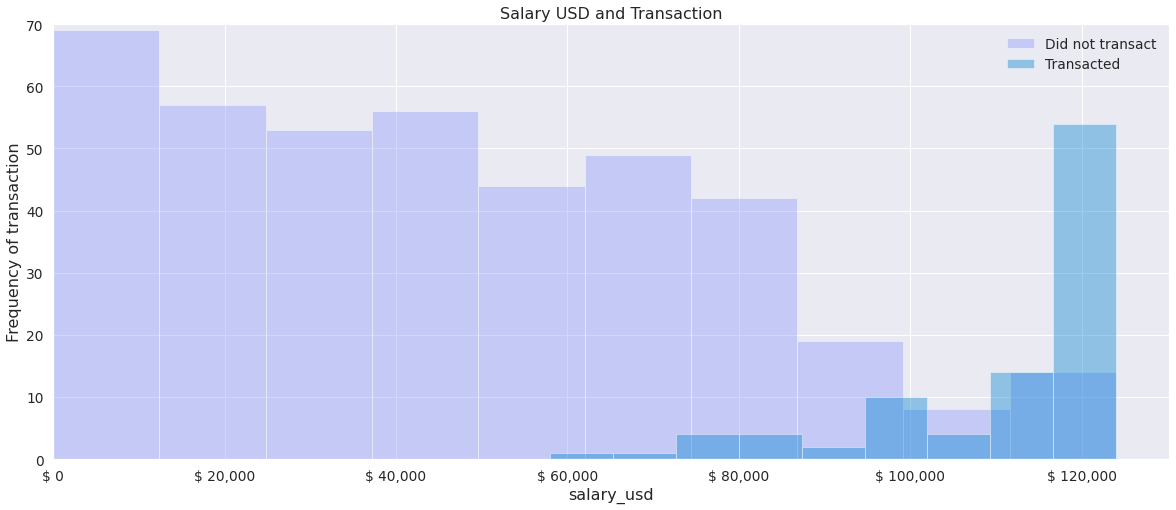

In [239]:
# Set the size of figure. 
rcParams['figure.figsize'] = (20, 8)

# Make distribution plot. 

data0 = transac_df['salary_usd'].loc[transac_df['transaction'] == 0]
data1 = transac_df['salary_usd'].loc[transac_df['transaction'] == 1]

ax = sns.distplot(data0, hist = True, color = '#8f99fb', kde = False)
ax = sns.distplot(data1, hist = True, color = '#0485d1', kde = False) 
plt.legend(['Did not transact', 'Transacted'])

# Set x and y lable name and the title of this scatterplot.
ax.set_xlabel('salary_usd', fontsize = 16)
ax.set_ylabel('Frequency of transaction', fontsize = 16)
ax.set_title('Salary USD and Transaction', fontsize = 16)

# Set x ticks. 
fmt = '$ {x:,.0f}'
tick = ticker.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick)

# Set the range of x and y axis
plt.xlim(0, None)
plt.ylim(0, 70)

It is evident that the frequency of transaction depends a great deal on the salary usd.

People tend to transact with only their salary has above 60,000 USD. 

Thus, salary usd can be a good predictor of the outcome variable.

# **Part 3 - Determine the causes for a transaction by using logistic regression**

## First of all, the scale of the feature of 'salary usd' is different from others that required to be normalized.

In [0]:
transac_df['salary_usd'] = transac_df['salary_usd'] / transac_df['salary_usd'].max()

## Logistic regression model development

In [0]:
# Set X and y.

X = transac_df.drop(['transaction'], axis = 1)
y = transac_df[['transaction']]

# Train and test sets: 70% and 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [0]:
# Initialize Logistic Regressor 
model = LogisticRegression(max_iter = 1000, random_state = 1)

In [243]:
# Fit the model
model.fit(X_train, y_train.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [244]:
# Let's score the model
print('Accuracy score: ', model.score(X_test, y_test).round(4))

Accuracy score:  0.9079


## To increase the accuracy score, I tried to use the grid search to identify the best hyperparameters for running logistic regression model.

In [245]:
# Build logistic model classifier
pip_logmod = make_pipeline(StandardScaler(),
                           LogisticRegression(max_iter = 1000, random_state = 0))
hyperparam_range = np.arange(0, 5, 0.1)
hyperparam_grid = {'logisticregression__penalty': ['l1', 'l2'],
                   'logisticregression__C':  hyperparam_range,
                   'logisticregression__fit_intercept': [True, False]}

# Utilize GridSearch to find the best hyperparameters for running logistic regression
gs_logmodel = GridSearchCV(pip_logmod, hyperparam_grid, scoring = 'accuracy', n_jobs= -1)

gs_logmodel.fit(X, y.values.ravel())

print(f'The best hyperparameters:\n')

for hyperparam in gs_logmodel.best_params_.keys():
    print(hyperparam[hyperparam.find("__") + 2:], ": ", gs_logmodel.best_params_[hyperparam])

print(f'Best 5-folds CV accuracy: {gs_logmodel.best_score_ :.4f}.')

The best hyperparameters:

C :  1.3
fit_intercept :  True
penalty :  l2
Best 5-folds CV accuracy: 0.9168.


## As the result, the average accuracy score have increased from 0.9079 to 0.9168.

## I will develop a final model here with all data. 

In [0]:
# Rerun Logistic Regressor 
model = LogisticRegression(C = 1.3, max_iter = 1000, random_state = 1)

In [247]:
# Fit the model
model.fit(X, y.values.ravel())

LogisticRegression(C=1.3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [248]:
# Let's score the model
print('Accuracy score: ', model.score(X, y).round(3))

Accuracy score:  0.921


We have the accuracy score 0.921 here, but this might just 1 time of best score. If in the 5 times of cross validation, the average accuracy score should be 0.9168. 

## Rank the welght value to see the importance (influence) of each feature (by absolute value)

In [249]:
# Print the model's coefficient value, and make a ranking dataframe.  

coeff_df = pd.DataFrame(X_train.columns)
coeff_df.columns = ['Features']

coeff_df['Coefficient'] = pd.Series(model.coef_[0])

coeff_df.sort_values(by = 'Coefficient', ascending = False)

# Sort the coefficient value by absolute value.
coeff_df.iloc[coeff_df['Coefficient'].abs().argsort()[::-1]].round(4)

,Features,Coefficient
0,salary_usd,6.6472
11,is_english_primary_language,1.4486
2,is_married,0.7692
12,previously_disney_customer,0.7277
13,previous_streaming_service_customer,0.6977
1,is_male,-0.6579
5,is_senior,-0.5006
9,is_renter,-0.4287
8,children_present,0.3634
4,is_professional,0.3046


## **Summary on the causes for transaction**

Seems like a part of my hypothesis is correct. 

The causes for transaction are:

1. salary_usd

2. previously_disney_customer

However, except the salary_usd, others coefficient value are reletively low. 

Salary usd has almost 6 times coefficient than the ranked 2 feature: previously disney customer. 



# **Part 4 - Assess the performance of my model**

Since I am dealing with inbalanced dataset, the accuracy is not the best metric to use. 

I would like to look at the following performance measures that can give more insight into the accuracy of the model than traditional classification accuracy:

- Confusion Matrix: A breakdown of predictions into a table showing correct predictions (the diagonal) and the types of incorrect predictions made (what classes incorrect predictions were assigned).
- Precision: A measure of a classifiers exactness.
- Recall: A measure of a classifiers completeness
- F1 Score (or F-score): A weighted average of precision and recall.
- ROC Curves: like precision and recall, accuracy is divided into sensitivity and specificity and models can be chosen based on the balance thresholds of these values.

*Reference*

- 8 Tactics to Combat Imbalanced Classes in Your Machine Learning Dataset:
https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

## 1. Accuracy score

In [250]:
acc = model.score(X_test, y_test).round(3) * 100
print('Accuracy score: ', acc, str('%'))

Accuracy score:  94.1 %


## 2. F1 score, precision and recall value

In [251]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       122
           1       0.92      0.77      0.84        30

    accuracy                           0.94       152
   macro avg       0.93      0.88      0.90       152
weighted avg       0.94      0.94      0.94       152



## 3. Visualize confusion matrix by heatmap

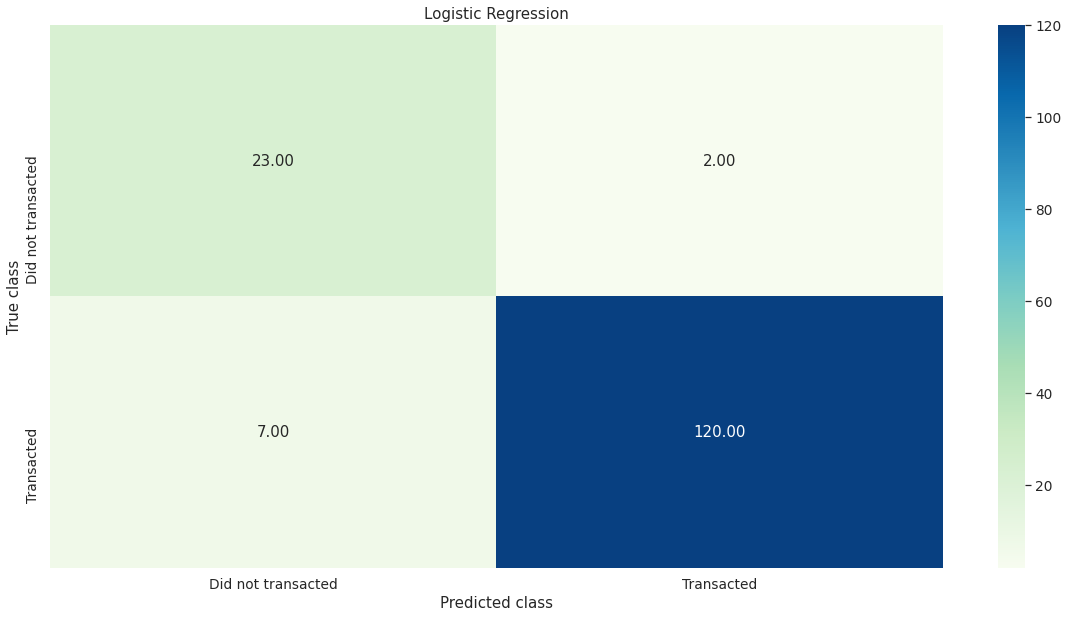

In [252]:
# Set the figure size. 
rcParams['figure.figsize'] = (20, 10)

# Compute confusion matrix.
logreg_y_pred = model.predict(X_test)
logreg_cm = metrics.confusion_matrix(logreg_y_pred, y_test, [1,0])

# Make a heatmap.
sns.heatmap(logreg_cm, annot=True, fmt='.2f', xticklabels = ['Did not transacted', 'Transacted'] , yticklabels = ['Did not transacted', 'Transacted'], cmap = 'GnBu')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Logistic Regression')
plt.savefig('logistic_regression')

## 4. Visualize ROC curve

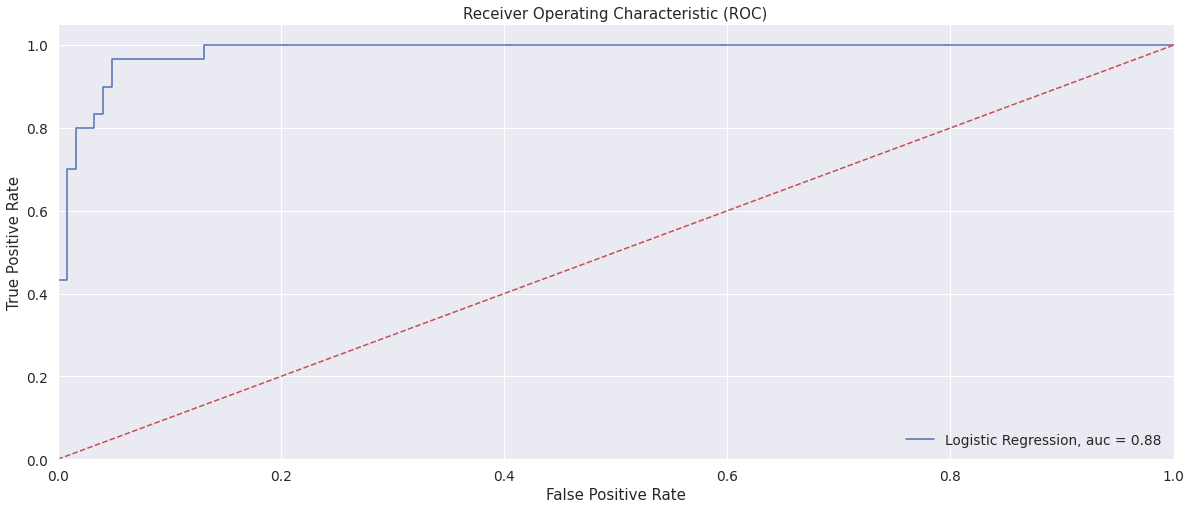

In [253]:
# Set the figure size. 
rcParams['figure.figsize'] = (20, 8)

# Compute ROC value. 
auc = roc_auc_score(y_test, model.predict(X_test)).round(2)
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

# Visualization. 
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression, auc = '+str(auc))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('ROC')
plt.show()

The receiver operating characteristic (ROC) curve is a common tool used with binary classifiers.

The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

# **Part 5 - Generate 5 sample predictions for input values of my choosing**

In [254]:
# Generate 5 samples for each variable. 
sample = {'salary_usd': [50000, 7000, 124000, 66000, 35000], 'previously_disney_customer': [0, 0, 1, 1, 0], 'is_english_primary_language': [0, 0, 1, 1, 1], 
          'is_married': [0, 1, 0, 1, 0], 'previous_streaming_service_customer': [1, 0, 1, 0, 1], 'children_present': [1, 0, 1, 1, 0], 
          'is_male': [1, 0, 0, 1, 1], 'is_renter': [0, 0, 0, 0, 0], 'is_senior': [0, 1, 0, 0, 0], 'is_single_income': [0, 0, 1, 0, 1], 
          'is_professional': [1, 0, 1, 0, 0], 'is_employed': [1, 1, 0, 1, 1], 'lives_in_house': [1, 1, 0, 0, 1], 'is_college': [0, 0, 1, 1, 0]}

# Convert dict to dataframe.
arbitrary_values = pd.DataFrame(data = sample)
arbitrary_values

,salary_usd,previously_disney_customer,is_english_primary_language,is_married,previous_streaming_service_customer,children_present,is_male,is_renter,is_senior,is_single_income,is_professional,is_employed,lives_in_house,is_college
0,50000,0,0,0,1,1,1,0,0,0,1,1,1,0
1,7000,0,0,1,0,0,0,0,1,0,0,1,1,0
2,124000,1,1,0,1,1,0,0,0,1,1,0,0,1
3,66000,1,1,1,0,1,1,0,0,0,0,1,0,1
4,35000,0,1,0,1,0,1,0,0,1,0,1,1,0


In [255]:
# Now, let's use the model to predict attrition for arbitrary values.

arbitrary_values.join(pd.DataFrame(model.predict(arbitrary_values), columns = {'Prediction'}).set_index([pd.Index(arbitrary_values.index)]))

,salary_usd,previously_disney_customer,is_english_primary_language,is_married,previous_streaming_service_customer,children_present,is_male,is_renter,is_senior,is_single_income,is_professional,is_employed,lives_in_house,is_college,Prediction
0,50000,0,0,0,1,1,1,0,0,0,1,1,1,0,1
1,7000,0,0,1,0,0,0,0,1,0,0,1,1,0,1
2,124000,1,1,0,1,1,0,0,0,1,1,0,0,1,1
3,66000,1,1,1,0,1,1,0,0,0,0,1,0,1,1
4,35000,0,1,0,1,0,1,0,0,1,0,1,1,0,1


In [256]:
# Create a data structure that contains the probabilities for a broad range.

exhaustive_data_df = pd.DataFrame(arbitrary_values)
prediction_df2 = pd.DataFrame(model.predict(exhaustive_data_df), columns = {'Prediction'}).set_index([pd.Index(exhaustive_data_df.index)])
probability_df2 = pd.DataFrame(model.predict_proba(exhaustive_data_df)).set_index([pd.Index(exhaustive_data_df.index)])
all_together_df2 = exhaustive_data_df.join(prediction_df2).join(probability_df2)
all_together_df2

,salary_usd,previously_disney_customer,is_english_primary_language,is_married,previous_streaming_service_customer,children_present,is_male,is_renter,is_senior,is_single_income,is_professional,is_employed,lives_in_house,is_college,Prediction,0,1
0,50000,0,0,0,1,1,1,0,0,0,1,1,1,0,1,0.0,1.0
1,7000,0,0,1,0,0,0,0,1,0,0,1,1,0,1,0.0,1.0
2,124000,1,1,0,1,1,0,0,0,1,1,0,0,1,1,0.0,1.0
3,66000,1,1,1,0,1,1,0,0,0,0,1,0,1,1,0.0,1.0
4,35000,0,1,0,1,0,1,0,0,1,0,1,1,0,1,0.0,1.0


In my sample, the logistic regression model predicts all 5 customers are likely to transact.  